In [1]:
import numpy as np
import pandas as pd
import os
import re
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn import metrics 
import scipy.io as spio
from nilearn.input_data import MultiNiftiMasker
from datetime import datetime

from sklearn.metrics import make_scorer,roc_auc_score,f1_score
from sklearn.model_selection import StratifiedKFold

absolute_path_fmri = '/home/kadajji/hydra-work/DELCODE_fMRI_GLMs_parametric/data/M0/glm/arcsin_CSF_pop_tpms_0p9_eroded/'
mask = '/home/kadajji/hydra-work/DELCODE_fMRI_GLMs_parametric/data/M0/glm/temp/GM_mask.nii'




# reading nifti files form the subjs folder
def read_nifti(absolute_path, regex_filter, smooth=None, mask=None):
    mask=mask
    start_time = datetime.now()
    regex_filter = str(regex_filter)
    # mask images and get data
    data_folder = str(absolute_path)
    if(mask==None):
        niftimasker = MultiNiftiMasker(smoothing_fwhm=smooth, n_jobs=-2)
    else:
        niftimasker = MultiNiftiMasker(smoothing_fwhm=smooth, n_jobs=-2, mask_img=mask)
    list_path = []
    subjs = []
    i = 0
    for dirs in os.listdir(data_folder):
        for root, dir, files in os.walk(data_folder + dirs):
            for file in files:
                if re.match(regex_filter, file):
                    matter_volume_path = root + '/' + file
                    list_path.append(matter_volume_path)
                    subjs.append(dirs)
                else:
                    pass
        i = i + 1
    print("Reading " + regex_filter + " volume data please wait.........")
    list_path = np.sort(list_path)
    subjs = np.sort(subjs)
    x = niftimasker.fit_transform(list_path)
    x = np.vstack(x)
    subjects_id = pd.DataFrame()
    subjects_id['subjs'] = subjs
    data_matrix = pd.DataFrame(x, dtype='float64')
    end_time = datetime.now()
    time = end_time - start_time
    print("Total time in minutes :", float(time.total_seconds() / 60))
    return data_matrix, subjects_id, niftimasker



# code to split train and test dataset
def train_test_split(dataset, split, random):
     train = dataset.sample(frac=split, random_state=random)

     #train = dataset.sample(frac=split, random_state=200)
     test = dataset.drop(train.index)
     return train, test
 
    

def get_data_mat(mat_url):
     dat = spio.loadmat(mat_url, squeeze_me=True)
     demo = dat['Demo']
     body = dat['Body']
     gen = dat['Gen']
     csf = dat['Csf']
     cog = dat['Cog']
     vol = dat['Vol']
     cog = cog['X'][()]
     csf = csf['X'][()]
     apoe = gen['apoe'][()]['X'][()]
     apoe = pd.DataFrame(apoe)
     apoe4 = ((apoe[0] == 4) + (apoe[1] == 4)) > 0
     delcode_data = pd.DataFrame()
     delcode_data['subjs'] = dat['IDs'][()]
     delcode_data['id'] = demo['IDn'][()]
     delcode_data['age'] = demo['age_bl'][()]
     delcode_data['bmi'] = body['bmi'][()]
     delcode_data['diag'] = demo['diag_bl'][()]
     delcode_data['sex'] = demo['sex'][()]
     delcode_data['apoe'] = apoe4
     delcode_data['edu'] = demo['edu'][()]
     delcode_data['fmem'] = cog[:,21]
     delcode_data['ptau'] = csf[:,4]
     delcode_data['abeta4240'] = csf[:,5]
     return delcode_data



/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [2]:
def norm(x):
    return (x-x.mean())/(x.std())

# read data by feature (GM brain tissue types)
data1, sub1,niftimasker = read_nifti(absolute_path_fmri, 'con_0005.nii', mask=mask)


Reading con_0005.nii volume data please wait.........


/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: Runtim

/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: Runtim

/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: Runtim

/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: Runtim

/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: Runtim

/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: Runtim

/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: Runtim

/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: Runtim

/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: Runtim

/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: Runtim

/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: Runtim

/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: Runtim

/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: Runtim

/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: Runtim

/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: Runtim

Total time in minutes : 0.6574586833333333


In [3]:
data1 = norm(data1)
data1 = data1.replace(np.nan, 0)

In [4]:
data1

,0,1,2,3,4,5,6,7,8,9,...,168417,168418,168419,168420,168421,168422,168423,168424,168425,168426
0,-0.167145,0.016862,-0.099613,-0.102776,0.152089,0.064600,0.239873,0.181124,0.321166,0.504961,...,0.382186,0.237182,0.542751,0.547141,0.295254,0.412794,0.256575,0.044384,0.146909,-0.122682
1,0.911377,0.586791,1.022629,1.260503,0.390191,1.067317,0.181608,0.719499,-0.151498,0.625958,...,0.653907,0.534085,0.048692,0.470126,0.660158,0.034790,0.271602,0.643876,0.099311,0.007561
2,0.582975,1.159642,0.704184,0.298008,1.165341,0.575632,1.007516,0.538283,0.862086,0.452509,...,0.863224,1.154431,0.509541,0.663178,0.837353,0.697626,0.607281,0.673977,0.873825,0.557116
3,-0.675786,0.332704,-0.112429,-0.303015,0.196853,0.013360,0.074708,0.067958,0.022798,0.701149,...,0.383657,0.241127,0.261690,0.325046,0.303185,0.240566,0.113028,-0.084875,0.218577,-0.083893
4,-0.242772,-0.534656,-0.459770,-0.245909,-0.693729,-0.550404,-0.713969,-0.496688,-0.567213,-0.282290,...,0.290456,0.374051,-0.154911,0.021438,0.228836,-0.160307,0.121065,0.308372,-0.035200,0.304221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553,-1.069556,-0.505404,-0.835831,-1.192620,-0.357236,-0.780764,-0.374941,-0.806365,-0.411710,-0.219059,...,-0.670683,-0.800261,-0.036604,-0.289369,-0.661913,0.082328,-0.119792,-0.463563,0.180063,0.039248
554,0.842772,1.549896,1.459325,1.184097,1.736321,1.880952,2.010290,1.976179,2.119794,0.340887,...,3.103052,3.198444,1.845622,2.379882,2.674273,1.765169,2.011705,2.169953,1.268773,1.471230
555,0.144096,0.287435,0.241639,0.206086,0.315660,0.321030,0.211909,0.342069,0.141003,-0.511463,...,-0.248396,-0.256512,-0.065487,-0.147276,-0.410818,0.239383,0.124650,-0.228324,0.564680,0.429536
556,0.525271,-0.372577,0.057214,0.543944,-0.355875,-0.062638,-0.428129,-0.318841,-0.552963,0.332662,...,0.285201,0.369893,0.377800,0.137032,0.131102,0.143837,-0.055866,-0.056916,-0.205482,-0.288121


In [5]:

# reading subjects covariate data
delcode_cov = '/home/kadajji/hydra-work/delcode_cov1079.mat'
delcode_data = get_data_mat(delcode_cov)
sub1['age'] = sub1.subjs.map(delcode_data.set_index('subjs')['age'])
sub1['edu'] = sub1.subjs.map(delcode_data.set_index('subjs')['edu'])
sub1['sex'] = sub1.subjs.map(delcode_data.set_index('subjs')['sex'])
sub1['diag'] = sub1.subjs.map(delcode_data.set_index('subjs')['diag'])
sub1['fmem'] = sub1.subjs.map(delcode_data.set_index('subjs')['fmem'])
sub1['apoe'] = sub1.subjs.map(delcode_data.set_index('subjs')['apoe'])
sub1['apoe'] = sub1['apoe'].map({True:1, False:0})    


   
subjects  = sub1[['subjs', 'age', 'sex', 'edu', 'fmem', 'diag', ]]
# excluded few subjects because of inconsistency in T1w images
exclude_subjects = ['0588be6c5', '0901942a8', '0c1c5ae77', '0df733308', '0e27a6de5', '0e3cd430b', '14136a5ce', '16cf80a1a', '19f47ee32', '1ad67792f', '1d48057fd', '1ece6ef85', '1eebab647', '1ef92e9c3', '3125073f4', '3300076e2', '3a018fc24', '4210b3c88', '46c3433d4', '475b9bfe2', '503be410d', '5659a73f6', '5b8721c3f', '5cbfe44a2', '625c4e8e1', '682305c91', '6b8442bc7', '6c06ac657', '6dc95ea8c', '72984fc3b', '74d781eee', '766b96f80', '781929efb', '7a3350a22', '7c86c18fc', '7e74ee245', '85eb9b1a2', '8e66edf5e', '9489a87de', '999bf662e', '9c8c5c08c', 'a5cceacea', 'a9b3982d2', 'ad0d19af0', 'ad73d5585', 'b093bca1e', 'b393e08ba', 'bbb5dedd3', 'c88ff511b', 'cd3bf904f', 'd23ebb73d', 'd310d786d', 'd4c29fe4b', 'd7af42c4d', 'e49cecc8c', 'e7967bcd4', 'eb95738e8', 'ee19c801d', 'f0c51137c', 'f2a767eaa', 'f30441648', 'f4ba91dc6', 'fa890e12f', 'ffa620116', 'fff6c90a3']
subjects = subjects[~subjects['subjs'].isin(exclude_subjects)]

subjects = subjects.dropna()

con5 = pd.DataFrame(data1, index=subjects.index)
con5 = pd.DataFrame(np.array(con5))
subjects.index  = con5.index
    

In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def create_confusion_matrix(test_label ,prediction, classifier):
    print(np.unique(test_label,return_counts=True))
    cm = confusion_matrix(test_label, prediction, labels=classifier.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=classifier.classes_)
    disp.plot()

    plt.show()

In [7]:

def plotting_roc_auc_curve(test_label, predict_test_prob):
    probs = predict_test_prob[:,1]
    fpr, tpr, threshold = metrics.roc_curve(test_label, probs)
    roc_auc = metrics.auc(fpr, tpr)

    # method I: plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.grid()
    plt.xlim([0, 1.1])
    plt.ylim([0, 1.1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [8]:
def train_model(Y_train_diag, Y_test_diag,X_train_diag, X_test_diag):
    
    param_grid = {'C': [i for i in np.arange(0.00001,.003,0.001)],
                  'gamma': [1, 0.1],
                  'kernel': ['linear']}

    grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3)
    # fitting the model for grid search
    grid.fit(X_train_diag, Y_train_diag.diag)

    # print best parameter after tuning
    print(grid.best_params_)
    # print how our model looks after hyper-parameter tuning
    print(grid.best_estimator_)

    # input the best params for c=0.001 & gamma=1   
    clf = svm.SVC(kernel='linear', C=grid.best_params_['C'], gamma=grid.best_params_['gamma'], probability=True)
    scores = cross_val_score(clf, X_train_diag, Y_train_diag.diag, cv=5, scoring='roc_auc')
    fit = clf.fit(X_train_diag, Y_train_diag.diag)

    predict_test_prob = clf.predict_proba(X_test_diag)

    #probs = predict_test_prob[:,1]

    #fpr, tpr, threshold = metrics.roc_curve(Y_test_diag.diag, probs)
    #roc_auc = metrics.auc(fpr, tpr)
    # calculate the g-mean for each threshold
    #gmeans = np.sqrt(tpr * (1-fpr))
    # locate the index of the largest g-mean
    #ix = np.argmax(gmeans)
    #print('Best Threshold=%f, G-Mean=%.3f' % (threshold[ix], gmeans[ix]))

    #y_pred = (probs > threshold[ix]).astype('float')

    #create_confusion_matrix(Y_test_diag.diag,y_pred,clf)
    #plotting_roc_auc_curve(Y_test_diag.diag,predict_test_prob)
    #confusion =  metrics.confusion_matrix(Y_test_diag.diag, y_pred)
    #TP, TN, FP, FN = confusion[1, 1], confusion[0, 0],confusion[0, 1],confusion[1, 0]
    #specificity = (TN / (TN + FP))
    #sensitivity = (TP / float(FN + TP))
    
    #print(" F1 score on test set ---- " , f1_score(Y_test_diag.diag, y_pred, average='weighted'))
    #print("weighted roc auc on test set", roc_auc_score(Y_test_diag.diag,clf.predict_proba(X_test_diag)[:, 1],average='weighted'))
    #print("cross validation scores", scores)
    #print("Specifity and sensitivity", specificity,sensitivity)
    return clf

In [9]:
def create_train_test(subjects,con5,disease,random):
    
    subjects_cn_mci = subjects[(subjects['diag'] ==0) | (subjects['diag']==disease)]
    subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})
    data_cn_mci = pd.DataFrame(con5, index=subjects_cn_mci.index)
    Y_train_diag, Y_test_diag = train_test_split(subjects_cn_mci,0.75, random)
    X_train_diag, X_test_diag = pd.DataFrame(data_cn_mci, index=Y_train_diag.index), pd.DataFrame(con5, index=Y_test_diag.index)
    return Y_train_diag, Y_test_diag,X_train_diag, X_test_diag


In [10]:
clf_MCI = pd.DataFrame()

for i in range(0,200):
    print(i)
    Y_train_diag, Y_test_diag,X_train_diag, X_test_diag = create_train_test(subjects,con5,2, i)
    clf = train_model(Y_train_diag, Y_test_diag,X_train_diag, X_test_diag)
    clf_MCI = clf_MCI.append(pd.DataFrame(clf.coef_))
    

0
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.4s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.9s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   4.1s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   4.2s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.9s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.7s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.576 total time=   3.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.606 total time=   4.1s
[CV 3/5] END .C=0.00101, gam

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.4s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.758 total time=   3.5s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   4.1s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   4.2s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.9s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.758 total time=   3.6s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   4.0s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.6s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.636 total time=   3.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.5s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.6s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.6s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   4.0s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.606 total time=   3.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.7s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.5s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   4.1s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.9s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   4.2s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   4.1s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   4.1s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.636 total time=   4.2s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.8s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   4.3s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   4.1s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   4.0s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   4.0s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.9s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   4.2s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.9s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.7s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.758 total time=   4.0s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.5s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   4.2s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.6s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.667 total time=   4.1s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.5s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.9s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.6s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.6s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.6s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.6s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   4.0s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.7s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.697 total time=   3.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.7s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   4.0s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   4.2s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.9s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   4.2s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   4.0s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   4.0s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   4.0s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.576 total time=   4.7s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.7s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.4s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.3s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.4s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.4s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.5s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.4s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.5s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.4s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.697 total time=   3.6s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.4s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.4s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.6s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   4.1s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   4.0s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.9s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.6s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.4s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.606 total time=   3.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.636 total time=   3.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   4.2s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   4.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   4.4s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.636 total time=   3.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.6s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   4.1s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.667 total time=   3.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.5s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.9s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.9s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.4s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.6s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.515 total time=   3.5s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.4s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.6s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.5s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.4s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.4s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.4s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.3s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.5s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.697 total time=   3.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.3s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.5s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.6s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.5s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.576 total time=   3.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.636 total time=   3.3s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.4s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.6s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.636 total time=   3.6s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.6s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.5s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.4s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.6s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.576 total time=   3.5s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   4.3s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   4.0s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.6s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.6s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.4s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.5s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.5s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.3s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.636 total time=   3.7s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.4s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.4s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.3s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.5s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   4.1s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   4.0s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.9s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   4.2s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.667 total time=   4.1s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.3s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.5s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.4s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.4s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.5s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.9s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.6s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.697 total time=   3.3s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.4s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   4.1s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.6s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.6s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.4s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.7s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.697 total time=   3.7s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.5s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.5s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.7s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   4.0s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.5s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.6s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.758 total time=   3.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.5s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.9s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.7s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.5s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   4.4s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.9s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.7s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.788 total time=   3.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.8s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.636 total time=   4.1s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.656 total time=   3.4s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.6s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.6s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.636 total time=   4.0s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.656 total time=   3.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   4.1s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.758 total time=   3.7s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.5s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.7s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   4.0s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.625 total time=   3.9s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.9s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.625 total time=   4.1s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.667 total time=   4.3s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.4s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.5s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.656 total time=   4.0s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.6s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   4.2s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.656 total time=   3.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.667 total time=   3.7s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.3s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.3s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.6s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.656 total time=   3.4s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   4.0s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.656 total time=   3.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.788 total time=   4.0s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.2s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.4s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.3s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.4s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.2s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.5s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.5s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.6s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.5s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.606 total time=   4.0s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.6s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.4s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.5s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.3s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   4.0s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.697 total time=   4.0s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.758 total time=   3.3s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.3s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.3s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.2s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.758 total time=   3.4s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   4.0s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.5s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.606 total time=   3.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.5s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.3s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.5s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.6s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.9s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.4s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.636 total time=   3.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.3s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.4s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   4.0s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   4.0s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.9s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   4.0s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.6s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.6s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.576 total time=   3.7s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.4s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.4s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.4s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.5s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.5s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.5s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.758 total time=   4.2s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.9s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.5s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.5s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.6s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   4.0s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   4.0s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.9s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.7s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.606 total time=   3.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.5s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.5s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.6s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.3s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   4.5s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   4.4s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.5s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.5s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.818 total time=   3.5s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.2s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.4s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.4s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.9s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.4s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.6s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.636 total time=   3.4s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.8s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   4.0s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   4.1s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.6s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.5s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.727 total time=   3.6s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.636 total time=   3.7s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.5s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.636 total time=   3.5s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.9s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.636 total time=   3.9s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   4.3s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.636 total time=   3.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.636 total time=   3.4s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.4s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.5s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.6s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.4s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.9s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.6s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.6s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.636 total time=   3.3s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.5s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.9s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   4.1s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   4.1s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.750 total time=   4.2s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   4.3s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   4.3s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.5s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.9s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.750 total time=   3.7s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.727 total time=   3.7s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.2s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.3s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.5s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.3s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.5s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.6s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.4s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.3s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.727 total time=   3.4s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.3s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.7s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   4.0s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.656 total time=   3.6s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.4s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.656 total time=   3.5s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.636 total time=   3.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.4s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.9s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.9s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.6s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.5s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.4s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.5s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.697 total time=   4.0s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   4.0s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.5s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.656 total time=   4.0s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.9s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.656 total time=   3.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.636 total time=   3.3s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.7s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   4.1s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.4s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.4s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.3s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.9s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.7s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.606 total time=   3.6s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.7s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.5s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.6s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.5s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.5s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.636 total time=   3.4s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.5s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.5s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.6s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.6s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.3s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.6s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.3s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.3s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.606 total time=   3.4s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.758 total time=   3.3s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.4s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.750 total time=   3.3s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.750 total time=   3.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.758 total time=   3.6s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.3s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.750 total time=   3.4s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.750 total time=   3.6s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.758 total time=   3.3s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.4s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   4.0s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.7s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.6s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.6s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.5s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.6s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.788 total time=   4.1s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.1s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.5s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.7s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.4s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.5s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.2s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.1s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.1s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.4s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.3s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.667 total time=   3.5s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   4.9s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   5.1s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   4.7s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.656 total time=   4.6s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   4.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   7.2s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   4.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   4.6s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.656 total time=   4.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   6.2s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.727 total time=   5.1s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   4.5s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   5.1s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   4.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   5.1s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   4.3s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   5.1s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   5.6s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   5.6s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   4.0s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   4.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.606 total time=   5.4s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   4.7s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   4.5s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   4.1s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   6.1s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   4.6s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   5.1s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   6.0s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   4.6s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   4.9s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   5.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.697 total time=   5.1s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   4.5s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   4.5s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   4.2s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   4.4s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   4.6s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.9s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   4.6s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   5.0s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   5.6s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   4.0s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.758 total time=   5.4s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   6.1s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.636 total time=   4.2s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   4.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   6.2s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   5.2s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   4.9s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.636 total time=   5.3s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   4.9s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   4.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.697 total time=   4.6s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   4.0s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   5.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   4.1s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   4.3s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   5.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   4.2s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   4.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   4.9s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   4.4s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.788 total time=   5.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.636 total time=   5.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.636 total time=   4.9s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   6.7s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   5.0s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.656 total time=   4.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.636 total time=   4.2s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.636 total time=   5.6s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   5.2s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   4.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.656 total time=   5.2s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.667 total time=   7.1s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   4.5s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   4.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   4.1s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   4.6s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   5.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   4.6s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   4.0s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   6.5s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   4.5s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.697 total time=   5.1s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   4.4s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   5.9s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.758 total time=   6.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.750 total time=   4.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   4.2s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   4.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.758 total time=   4.4s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.750 total time=   5.1s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   4.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.697 total time=   5.6s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.7s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   7.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   4.0s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   7.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   4.6s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   8.6s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   7.9s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   5.3s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   7.1s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   6.1s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.697 total time=   4.6s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.758 total time=   3.4s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.4s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.3s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.4s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.4s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.758 total time=   3.6s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.6s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.3s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.6s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.667 total time=   3.7s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.2s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.594 total time=   3.6s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.656 total time=   3.5s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.4s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.6s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.594 total time=   3.5s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.656 total time=   3.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.636 total time=   3.5s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.3s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.636 total time=   3.2s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.1s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.3s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.1s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.636 total time=   3.4s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.6s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.5s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   4.0s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.697 total time=   3.7s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.3s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.5s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.0s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.2s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.750 total time=   3.2s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.0s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.3s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.4s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.750 total time=   3.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.788 total time=   3.7s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.2s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.3s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.7s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.2s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.656 total time=   3.3s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.3s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.1s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.4s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.4s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.656 total time=   3.4s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.727 total time=   3.4s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.1s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.3s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.5s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.5s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.3s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.5s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.4s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.4s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.3s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.606 total time=   3.2s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.5s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.4s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.3s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.5s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.4s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.4s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.5s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.636 total time=   3.6s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.5s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.4s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.6s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.2s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.3s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.3s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.3s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.4s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.4s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.697 total time=   3.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.5s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.3s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.7s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.4s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.6s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.3s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   4.0s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.6s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.3s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.636 total time=   3.7s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.4s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.5s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.5s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.4s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.4s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.3s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.2s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.636 total time=   3.7s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.2s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.4s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.4s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.5s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.5s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.4s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.4s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.758 total time=   3.5s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.2s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.3s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.3s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.5s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.750 total time=   3.9s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.5s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.9s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.4s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.750 total time=   3.2s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.818 total time=   3.5s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.2s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.1s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.3s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   4.0s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.6s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.6s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.4s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.4s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.4s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.6s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.788 total time=   3.2s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.2s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.636 total time=   3.5s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.5s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.6s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.656 total time=   3.5s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.4s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.636 total time=   3.3s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.3s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.4s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.656 total time=   3.3s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.606 total time=   3.4s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.3s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.3s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.606 total time=   3.3s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.6s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.656 total time=   3.4s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.5s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.6s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.606 total time=   3.3s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.656 total time=   3.7s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.727 total time=   3.5s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.3s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.4s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.5s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.750 total time=   3.5s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.750 total time=   3.5s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.5s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.4s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.6s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.750 total time=   3.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.750 total time=   3.6s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.636 total time=   3.7s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.7s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.2s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.3s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.6s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.6s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.5s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.5s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.6s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.606 total time=   3.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   4.0s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.9s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.5s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.6s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.5s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.6s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.697 total time=   3.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.6s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.5s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.6s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.2s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.4s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.3s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.697 total time=   3.6s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.5s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.758 total time=   3.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.758 total time=   3.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.750 total time=   3.5s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.750 total time=   3.9s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.4s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.758 total time=   3.3s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.758 total time=   3.4s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.750 total time=   3.1s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.750 total time=   3.6s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.697 total time=   3.5s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.2s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.5s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   4.1s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.750 total time=   3.6s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.2s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.3s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   4.0s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.750 total time=   3.4s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.727 total time=   3.5s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.5s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.5s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.3s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.4s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.750 total time=   3.6s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.6s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.5s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.6s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.3s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.750 total time=   3.3s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.727 total time=   3.5s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.2s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.5s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.750 total time=   3.6s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.4s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.750 total time=   3.3s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.6s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.727 total time=   3.6s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.4s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.3s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.6s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.9s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.5s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   4.0s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   4.1s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.788 total time=   3.6s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.2s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.2s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.3s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.750 total time=   3.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.3s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.6s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.2s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.750 total time=   3.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.4s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.697 total time=   3.4s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.4s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.7s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.6s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.3s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.5s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.667 total time=   3.4s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.2s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.4s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.0s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.2s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.4s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.4s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.4s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.6s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.6s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.758 total time=   4.0s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.4s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.3s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.5s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.4s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.5s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.7s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.606 total time=   4.0s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.636 total time=   3.3s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.758 total time=   3.5s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.636 total time=   3.5s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.656 total time=   3.4s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.5s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.636 total time=   3.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.758 total time=   3.5s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.636 total time=   3.6s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.656 total time=   3.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.7s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.636 total time=   3.4s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.4s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.1s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.3s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.750 total time=   3.3s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.4s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.4s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.4s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.3s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.750 total time=   3.3s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.5s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.788 total time=   3.3s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.2s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.4s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.4s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.3s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   4.1s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.6s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.9s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.5s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.6s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.667 total time=   3.6s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.3s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.3s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.7s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.3s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.5s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.4s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.2s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.5s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.5s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.5s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.667 total time=   4.0s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.2s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.4s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.5s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.656 total time=   3.6s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.656 total time=   3.3s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.2s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.6s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.656 total time=   3.2s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.656 total time=   3.3s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.636 total time=   3.6s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.2s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.4s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.5s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.5s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.1s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.3s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.2s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.4s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.5s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.758 total time=   3.5s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.4s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.5s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   4.0s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.3s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.3s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.5s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.4s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.4s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.727 total time=   3.5s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.3s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.3s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.4s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.4s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.2s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.5s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.4s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.4s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.4s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.758 total time=   3.5s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.2s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.0s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.4s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.1s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.2s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.3s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.2s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.3s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.6s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.788 total time=   3.5s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.758 total time=   3.4s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.2s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.750 total time=   3.3s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.2s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.758 total time=   3.3s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.3s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.5s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.750 total time=   3.5s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.3s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.667 total time=   3.4s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.4s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.6s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.3s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.2s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.4s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.667 total time=   3.4s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.5s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   4.2s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.4s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   4.0s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.656 total time=   3.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.5s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.5s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.3s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.5s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.656 total time=   3.5s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.545 total time=   3.4s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.5s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.9s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.5s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.3s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.4s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.3s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.4s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.5s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.6s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.727 total time=   3.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.4s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.5s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.7s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.5s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.5s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.2s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.4s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.5s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.6s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.5s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.697 total time=   3.5s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.5s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.636 total time=   4.1s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.4s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.4s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.636 total time=   3.2s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.1s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.4s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.4s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.697 total time=   3.4s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.4s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.5s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   4.1s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.6s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   4.1s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   4.0s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.6s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.5s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.7s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.788 total time=   3.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.3s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.5s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.4s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.4s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.3s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.3s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.6s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.4s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.4s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.2s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.667 total time=   3.7s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.2s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.3s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.5s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.750 total time=   3.4s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.5s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.1s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.750 total time=   3.5s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.3s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.545 total time=   4.0s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.2s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.3s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.2s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.6s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.3s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.5s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.6s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.727 total time=   3.5s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.4s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.5s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.3s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.781 total time=   3.6s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.6s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.5s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   4.0s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.9s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.781 total time=   3.3s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.6s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.667 total time=   3.7s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.4s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.5s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.5s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.4s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.750 total time=   3.4s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.4s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.4s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.6s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.750 total time=   3.4s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.667 total time=   4.1s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.8s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   4.0s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.5s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.5s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.4s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.4s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.4s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   4.1s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.606 total time=   4.0s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.4s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.5s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   4.0s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.4s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.4s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   4.0s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.2s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.6s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.606 total time=   3.7s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.3s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.4s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.5s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.3s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.5s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.5s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.5s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.3s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.3s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.667 total time=   3.4s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.4s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.5s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.3s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.5s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.5s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.4s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.5s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.2s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.7s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.636 total time=   3.5s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.7s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   4.2s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.4s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.625 total time=   3.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.5s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.2s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.4s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   4.0s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.625 total time=   3.5s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.788 total time=   3.4s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.758 total time=   3.3s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.4s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.750 total time=   3.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   4.0s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.758 total time=   3.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.750 total time=   3.5s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.727 total time=   3.6s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.4s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.9s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.6s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.6s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.4s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.6s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.4s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.6s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.758 total time=   3.4s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.3s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.3s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.5s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.5s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.4s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.3s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.576 total time=   3.6s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.1s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.5s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.5s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.656 total time=   3.4s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.6s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.4s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.9s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.6s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.656 total time=   3.6s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.2s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.667 total time=   3.7s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.4s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.5s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.5s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.5s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.3s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.3s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.5s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.6s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.4s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.697 total time=   3.5s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.7s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   4.0s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.4s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.3s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.4s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.5s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.5s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.4s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.6s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.758 total time=   3.6s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.4s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.3s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   4.1s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.6s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.3s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.6s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.697 total time=   3.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.3s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.5s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.636 total time=   3.4s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.6s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.9s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.6s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.5s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.636 total time=   3.4s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.5s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.3s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.697 total time=   3.6s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.4s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.3s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.636 total time=   3.5s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.750 total time=   3.3s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.5s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.636 total time=   3.6s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.750 total time=   3.1s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.3s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.667 total time=   3.2s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.8s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   4.1s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.5s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.5s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.6s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.5s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.4s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.3s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.5s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.6s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.727 total time=   3.5s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.1s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.3s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.6s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.656 total time=   3.4s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.4s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.4s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.6s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.5s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.656 total time=   3.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.697 total time=   3.5s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.3s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.758 total time=   3.2s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.2s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.750 total time=   3.4s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.4s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.758 total time=   3.2s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.2s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.750 total time=   3.5s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.3s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.788 total time=   3.5s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.1s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.3s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.4s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.4s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.750 total time=   3.5s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.2s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.6s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.4s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.5s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.750 total time=   3.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.758 total time=   3.5s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.3s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.5s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.4s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.3s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.5s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.6s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.3s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.4s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.697 total time=   3.4s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.0s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.636 total time=   3.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.606 total time=   3.2s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.4s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.5s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.636 total time=   3.4s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.606 total time=   3.4s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.4s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.4s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.576 total time=   3.7s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.1s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.2s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.3s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.4s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.3s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.4s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.1s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.2s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.2s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.3s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.667 total time=   3.5s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.3s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.2s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.3s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.3s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.3s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.4s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.1s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.4s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.1s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.3s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.606 total time=   3.3s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.5s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.4s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.3s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.9s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.6s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.4s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.4s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.3s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.667 total time=   3.4s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.3s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.4s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.3s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.4s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.4s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.3s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.5s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.576 total time=   3.3s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.7s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.656 total time=   3.4s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.2s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.4s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.2s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.656 total time=   3.7s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.606 total time=   3.4s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.3s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.3s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.6s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.5s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.3s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.3s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.6s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.606 total time=   3.4s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.758 total time=   3.3s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.9s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.5s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.5s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.4s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.758 total time=   3.3s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.5s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.4s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.5s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.5s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.697 total time=   4.0s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.3s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.7s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.6s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.6s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.6s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.5s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.5s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   4.0s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.5s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.606 total time=   3.3s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.1s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.2s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.6s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.750 total time=   3.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.4s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.5s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.6s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.750 total time=   3.5s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.667 total time=   3.3s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.8s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.9s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.9s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.6s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.576 total time=   3.3s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.3s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.5s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.3s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.625 total time=   3.5s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.5s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.4s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.625 total time=   3.5s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.3s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.667 total time=   3.5s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.2s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.5s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.5s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.2s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.750 total time=   3.3s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.3s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.3s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.5s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.5s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.750 total time=   3.5s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.667 total time=   4.0s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.4s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   4.0s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.5s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.9s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.9s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.636 total time=   3.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.5s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   4.0s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.6s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   4.0s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.9s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   4.0s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.788 total time=   3.6s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.4s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   4.0s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   4.0s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.6s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.6s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.5s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.818 total time=   3.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.636 total time=   4.2s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   4.0s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.656 total time=   3.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.6s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.6s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.636 total time=   3.6s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.9s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.656 total time=   3.6s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   4.0s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.606 total time=   3.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.636 total time=   3.5s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.9s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.636 total time=   3.9s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.636 total time=   4.1s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.9s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.636 total time=   3.9s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   4.0s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.545 total time=   4.2s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.7s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.750 total time=   4.2s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   4.0s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.6s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.4s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.750 total time=   3.4s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.727 total time=   4.2s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.3s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   4.3s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.6s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.4s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   4.0s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.6s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.7s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.455 total time=   3.7s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.5s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.5s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.9s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.6s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.5s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.727 total time=   3.7s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.9s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.697 total time=   3.6s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.4s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   4.3s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   4.3s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   4.0s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.9s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   4.0s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.727 total time=   4.0s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.9s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   4.1s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.6s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.9s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   4.0s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.5s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.7s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.758 total time=   4.0s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   4.0s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.576 total time=   3.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.625 total time=   3.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   4.3s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   4.3s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.576 total time=   4.5s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.625 total time=   4.4s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.636 total time=   4.0s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.8s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   4.0s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.656 total time=   3.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.9s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.9s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   4.1s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.656 total time=   3.6s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   4.0s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.667 total time=   3.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.656 total time=   3.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.9s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.6s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.656 total time=   4.0s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.727 total time=   3.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.5s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.750 total time=   3.6s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.9s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   4.0s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.750 total time=   4.5s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.606 total time=   4.1s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.9s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   4.2s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   4.0s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.9s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.9s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   4.1s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   4.1s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   4.1s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.727 total time=   4.1s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.9s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   4.2s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   4.3s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   4.1s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.9s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.6s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   4.0s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.697 total time=   3.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.5s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   4.2s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   4.2s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   4.1s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.9s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.6s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.9s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   4.1s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.667 total time=   3.6s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.9s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   4.4s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.7s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   4.4s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   4.3s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   4.1s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   4.1s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.9s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   4.0s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.667 total time=   4.0s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.7s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.9s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.7s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.656 total time=   3.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.9s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   4.1s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   4.0s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   4.1s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.656 total time=   4.0s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   4.2s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.636 total time=   3.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.9s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.7s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   4.1s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   4.0s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.636 total time=   4.1s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.5s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   4.0s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.6s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.6s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.6s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.6s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.667 total time=   3.7s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.5s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   4.0s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   4.0s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   4.2s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   4.0s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   4.1s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   4.2s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   4.0s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.545 total time=   3.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   4.1s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   4.0s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   4.0s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   4.3s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.9s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.667 total time=   3.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.7s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.758 total time=   3.5s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   4.5s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.758 total time=   3.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   4.0s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.7s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.697 total time=   4.0s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.8s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   4.0s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   4.0s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.5s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.6s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.727 total time=   4.0s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.9s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.9s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   4.0s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.6s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   4.3s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.667 total time=   4.4s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.9s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.750 total time=   3.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   4.0s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   4.1s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   4.4s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.750 total time=   4.2s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.697 total time=   4.2s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.4s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.7s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   4.5s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   4.1s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.9s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   4.0s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   4.0s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.9s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.606 total time=   3.7s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.4s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.5s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.7s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.656 total time=   3.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.6s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.5s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.4s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.6s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.656 total time=   3.5s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.697 total time=   3.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.2s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.5s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   4.0s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.750 total time=   3.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.6s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.6s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.750 total time=   3.5s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.758 total time=   4.0s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.4s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.562 total time=   3.3s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.6s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   4.0s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.562 total time=   3.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.4s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.606 total time=   3.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.5s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.7s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.6s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   4.2s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.5s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.6s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.697 total time=   3.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.0s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.5s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.9s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   4.0s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.9s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   4.0s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   4.0s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.758 total time=   4.0s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.5s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.9s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.4s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.6s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.6s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   4.2s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   4.0s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.5s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.606 total time=   4.2s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.625 total time=   3.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.3s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.6s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.625 total time=   3.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.6s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.697 total time=   3.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.758 total time=   3.4s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.758 total time=   3.7s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.750 total time=   3.4s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   4.0s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.758 total time=   3.4s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.6s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.758 total time=   3.6s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.750 total time=   3.6s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.4s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.758 total time=   4.0s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.5s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.5s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   4.1s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.5s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   4.0s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.5s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.6s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.6s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.7s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.667 total time=   3.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.4s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.5s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.3s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.3s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   4.0s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.3s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.5s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.6s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.4s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.727 total time=   3.7s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.8s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.606 total time=   3.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.7s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.4s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.656 total time=   4.0s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.606 total time=   3.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.3s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.656 total time=   3.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.667 total time=   3.6s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.7s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   4.0s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.750 total time=   3.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.5s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.5s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.6s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   4.0s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.750 total time=   3.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.727 total time=   3.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.8s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.5s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.5s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.750 total time=   3.9s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   4.0s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.6s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.750 total time=   3.4s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.667 total time=   3.7s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.3s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.4s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.7s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.5s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.750 total time=   3.5s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.1s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.5s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.6s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.4s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.750 total time=   3.6s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.758 total time=   3.6s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.6s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.656 total time=   4.4s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.4s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   4.0s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.5s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.9s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.656 total time=   4.0s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.758 total time=   3.6s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.636 total time=   4.0s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.7s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.6s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.5s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.636 total time=   3.5s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.4s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.6s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.455 total time=   3.6s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.4s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.5s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.6s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.4s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.3s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.4s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.5s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.4s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   4.1s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.788 total time=   3.4s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.3s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.636 total time=   3.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.6s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.4s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.636 total time=   3.4s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.6s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.9s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.515 total time=   3.5s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.4s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.5s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.6s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.5s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.4s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   4.1s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.3s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.667 total time=   3.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   4.2s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.9s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.750 total time=   3.5s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.5s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.4s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.9s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.5s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.750 total time=   3.4s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.6s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.788 total time=   3.6s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.3s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.636 total time=   3.5s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.4s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.4s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.6s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.5s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.636 total time=   3.4s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.3s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.5s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.697 total time=   3.4s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.1s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.2s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.3s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.750 total time=   3.2s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.2s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.2s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.2s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.2s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.750 total time=   3.2s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.1s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.606 total time=   3.2s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.5s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.1s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.5s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.9s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.5s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.5s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.5s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.6s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   4.2s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.667 total time=   3.5s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.4s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.9s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   4.1s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.2s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.4s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.758 total time=   3.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.1s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.5s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.656 total time=   3.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.3s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.4s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.5s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.5s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.656 total time=   3.5s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.667 total time=   3.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.4s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.3s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.9s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.750 total time=   3.4s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.4s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.5s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.4s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.3s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.750 total time=   3.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.7s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.727 total time=   3.5s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.636 total time=   3.3s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.636 total time=   3.4s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.4s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.656 total time=   3.4s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.636 total time=   3.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.636 total time=   3.4s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.3s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.3s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.656 total time=   3.5s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.667 total time=   4.1s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.5s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   4.0s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.5s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.5s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.6s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.5s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.667 total time=   3.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.7s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.5s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.3s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.5s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.5s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.6s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.9s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.5s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.667 total time=   3.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.3s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.3s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.5s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.750 total time=   3.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.4s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.3s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.9s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.750 total time=   3.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.4s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.697 total time=   3.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.4s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.667 total time=   3.5s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.697 total time=   3.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.688 total time=   3.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.667 total time=   3.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.697 total time=   3.5s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.6s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.688 total time=   3.7s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.606 total time=   3.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.4s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.719 total time=   3.5s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.6s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.5s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.6s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.719 total time=   3.5s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.727 total time=   3.6s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

In [11]:
clf_AD = pd.DataFrame()

for i in range(0,200):
    Y_train_diag, Y_test_diag,X_train_diag, X_test_diag = create_train_test(subjects,con5,5, i)
    clf = train_model(Y_train_diag, Y_test_diag,X_train_diag, X_test_diag)
    clf_AD = clf_AD.append(pd.DataFrame(clf.coef_))
    

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   2.9s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   3.0s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   3.2s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   3.3s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.2s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.2s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.923 total time=   2.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.1s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.2s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.923 total time=   2.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   2.8s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.1s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.1s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   2.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.923 total time=   3.2s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.1s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.0s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.1s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.0s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.846 total time=   3.0s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   2.8s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   2.9s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.962 total time=   2.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   2.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.4s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   2.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.962 total time=   3.0s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.1s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   2.8s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.2s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.1s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   3.1s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.923 total time=   3.0s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.1s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.1s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.2s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.2s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.2s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.2s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   3.3s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.1s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.9s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.0s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.9s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.846 total time=   2.7s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.0s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.1s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.2s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.0s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.0s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.0s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.5s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.1s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.6s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.846 total time=   2.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.1s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.9s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.2s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.962 total time=   2.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.6s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.5s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.5s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.923 total time=   2.7s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.5s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.1s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.6s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.923 total time=   2.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.1s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.3s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.1s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   2.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   2.7s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.0s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   3.3s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   2.7s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   2.9s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.1s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.962 total time=   3.1s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   2.9s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.4s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.2s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.4s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   2.9s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.2s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.1s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.923 total time=   3.1s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   2.9s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.9s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   2.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.1s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.9s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.3s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.1s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.3s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.9s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.0s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.2s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.846 total time=   3.2s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   2.7s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   3.1s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   3.3s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   2.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   3.0s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   3.1s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   2.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   2.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.923 total time=   2.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   2.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   2.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.5s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.962 total time=   3.1s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.3s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.0s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.0s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.1s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.5s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.2s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.9s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.7s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.1s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.9s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.0s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.0s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.9s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.6s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.3s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.3s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.0s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.0s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   3.5s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.1s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.2s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   2.9s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.2s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   3.1s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.846 total time=   3.1s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.1s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.5s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.3s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.3s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.2s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.2s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.1s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.0s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   3.4s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.4s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.4s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.2s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.1s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.2s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.1s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.923 total time=   3.2s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.2s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.0s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.0s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.808 total time=   2.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.0s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.0s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.0s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.0s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.808 total time=   2.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.846 total time=   3.1s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.1s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.9s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.1s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   3.2s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   3.2s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   3.1s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.1s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.923 total time=   3.0s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.0s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.0s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.2s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.1s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.846 total time=   3.1s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.8s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.3s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.7s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.2s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.1s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.1s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.923 total time=   3.0s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.0s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.6s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.2s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.962 total time=   2.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.5s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.5s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.6s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.4s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.5s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.5s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.846 total time=   2.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.6s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.6s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.6s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.923 total time=   2.7s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.7s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.2s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.9s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.6s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.846 total time=   2.7s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.0s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.0s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.4s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.1s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.6s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.9s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.0s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.846 total time=   3.3s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.1s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.6s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.6s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.6s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.846 total time=   3.1s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.0s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.7s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.6s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.5s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.7s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.1s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.6s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.6s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.6s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.5s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.5s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.6s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.6s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.6s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.5s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.6s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.6s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.4s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   2.5s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.5s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   2.9s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.5s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.6s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.6s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.923 total time=   2.6s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.846 total time=   2.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.5s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.6s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.5s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.5s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.6s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.1s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.923 total time=   3.3s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.4s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.9s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.1s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.2s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.2s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.1s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   3.1s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.5s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   3.1s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.5s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   2.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.4s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.1s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.7s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.846 total time=   3.2s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.2s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.6s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.6s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.0s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   2.8s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   2.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   3.0s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   2.9s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.6s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.923 total time=   3.0s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.7s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.9s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.1s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.1s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.9s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.1s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.1s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.769 total time=   3.0s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.923 total time=   2.7s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.6s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.6s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.923 total time=   2.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.5s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.6s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.5s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.846 total time=   2.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.1s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.6s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.5s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.5s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.923 total time=   2.6s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.5s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.0s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.2s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.846 total time=   2.7s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.2s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.0s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.1s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.846 total time=   2.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   3.1s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.1s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   2.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.6s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.923 total time=   2.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   2.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   2.6s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.5s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.6s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.923 total time=   2.7s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   2.5s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   2.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   2.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   2.6s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   2.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   2.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=1.000 total time=   3.1s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.3s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.9s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.1s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.1s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.0s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.7s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.6s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.6s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.6s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   3.1s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.1s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.1s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.6s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   3.0s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   2.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.5s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.5s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.6s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.5s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.962 total time=   3.1s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.9s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.9s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.9s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.0s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.6s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.846 total time=   2.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.2s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.2s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.1s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.923 total time=   2.7s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.3s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.846 total time=   2.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   2.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   2.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.3s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   2.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   2.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.923 total time=   3.2s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.6s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.1s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.2s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   3.1s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.9s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.3s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.1s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.1s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.9s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.1s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   3.4s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.0s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.6s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.0s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.923 total time=   3.3s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   3.1s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   2.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   2.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.6s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.5s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   2.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   2.6s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   2.6s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   2.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.2s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.2s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   3.1s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.1s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.2s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.923 total time=   3.0s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   2.7s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.1s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   2.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.923 total time=   2.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   2.7s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   2.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   2.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   2.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.1s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.0s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.9s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.4s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.0s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.2s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.9s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.0s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.923 total time=   2.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.6s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.1s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.5s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.0s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.6s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.6s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.923 total time=   3.1s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.9s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.6s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.6s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.7s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.6s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.5s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.9s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.7s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.3s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.2s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.0s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.923 total time=   3.2s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.9s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.1s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.9s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.5s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.923 total time=   3.1s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.5s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.5s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.9s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.9s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.1s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.1s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.0s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.1s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.9s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.846 total time=   2.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.0s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.6s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.2s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   3.4s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.1s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.5s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.846 total time=   2.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.0s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.9s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.6s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.846 total time=   2.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.1s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.5s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.6s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.6s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.7s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.923 total time=   2.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   2.5s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   3.0s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   2.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   2.6s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.923 total time=   3.0s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   2.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   2.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   2.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   2.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   2.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   2.6s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   2.6s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   2.9s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.6s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.923 total time=   2.7s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.5s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.0s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.1s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.5s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.846 total time=   2.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   2.5s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   2.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   2.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   2.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   2.6s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   2.6s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.2s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.923 total time=   2.6s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.5s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.7s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.0s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.9s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.5s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.6s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.6s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.923 total time=   3.2s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.9s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.923 total time=   2.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.0s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.846 total time=   2.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.7s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.2s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.1s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.1s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.1s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.846 total time=   3.4s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.9s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.0s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   2.9s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.1s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   2.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.923 total time=   3.0s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.9s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.9s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.9s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.1s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.808 total time=   3.0s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   2.8s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   3.1s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   2.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   2.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.2s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.1s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.9s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.1s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.9s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.3s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.0s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.3s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.2s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   3.1s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   2.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.1s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   2.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.923 total time=   3.0s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.1s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.2s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.2s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.1s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.1s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   2.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   2.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.923 total time=   3.0s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   2.7s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.2s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.1s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   3.0s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.923 total time=   2.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.2s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.4s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.1s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.1s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.2s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.5s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   3.1s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.0s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.9s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.7s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   3.1s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.2s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   3.2s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   2.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.1s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.1s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   2.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.923 total time=   3.0s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   2.9s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   2.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   3.1s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   3.0s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   2.9s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   3.0s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   2.7s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   2.9s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   3.0s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   2.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   3.0s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   2.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.923 total time=   3.0s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   3.1s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.0s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.1s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.1s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   3.5s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.2s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.0s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.6s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.923 total time=   3.1s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.1s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.2s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.923 total time=   3.3s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.2s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.1s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.0s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.4s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   3.6s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   2.5s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   2.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   2.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   2.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.6s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.6s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.6s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.6s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.846 total time=   2.7s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.6s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.6s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.6s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.6s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.1s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.7s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.7s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.6s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.4s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.6s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.0s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.1s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.4s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.2s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   3.4s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.5s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.846 total time=   2.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.9s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.9s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.6s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.6s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.1s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.0s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.0s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.6s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.3s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.2s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.962 total time=   2.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   2.7s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   2.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.6s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.5s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.962 total time=   2.7s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.0s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.6s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.7s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.923 total time=   3.1s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.9s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.9s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.9s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.1s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.6s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.923 total time=   3.1s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.1s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   3.2s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.7s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.923 total time=   2.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.2s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.846 total time=   3.1s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.923 total time=   2.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.2s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.2s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.2s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.9s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.9s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.1s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   3.1s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.5s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.0s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.1s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.9s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.923 total time=   3.6s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   2.7s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   2.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.923 total time=   2.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   2.9s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.1s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.1s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   3.2s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.923 total time=   2.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.3s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.1s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.4s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.1s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.3s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   3.4s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.1s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   3.1s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.2s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.1s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.0s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.5s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.923 total time=   2.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.5s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.9s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.6s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   3.1s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.1s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.1s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.1s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.1s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.962 total time=   2.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.1s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.9s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.0s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.9s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.0s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.9s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.0s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.2s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.7s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.0s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.0s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.3s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.5s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.1s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.2s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   3.3s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.0s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.7s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.0s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.0s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.6s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.7s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   3.1s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.5s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.5s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.5s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.6s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.4s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.5s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.923 total time=   2.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.4s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.5s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.5s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.5s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.6s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.6s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   2.5s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   2.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   2.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   2.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   2.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   3.0s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   2.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   3.1s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.923 total time=   2.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.0s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.6s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   3.1s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.1s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.2s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.1s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.1s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.3s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.1s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.2s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.2s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.2s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.1s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.3s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.0s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.3s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.846 total time=   2.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.3s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   3.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.1s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.3s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   3.1s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   2.7s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   3.1s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.2s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   2.9s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   2.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.2s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.923 total time=   2.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.0s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.1s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.7s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   3.2s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.9s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.0s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.9s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.808 total time=   2.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.0s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.1s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.9s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.9s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.0s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.1s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.2s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   2.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.2s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.1s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   2.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   2.8s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.1s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.1s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   3.1s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.2s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.1s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.923 total time=   3.1s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   2.8s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   2.9s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   3.0s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   2.9s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.2s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.962 total time=   2.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.2s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.846 total time=   2.7s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.1s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.7s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.0s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.6s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.6s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.0s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.1s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.2s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.923 total time=   2.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.1s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.1s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.923 total time=   2.7s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.923 total time=   3.0s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   3.0s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   3.0s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.2s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.6s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.923 total time=   2.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.1s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.6s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.3s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.1s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.846 total time=   3.1s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.923 total time=   2.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.6s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.6s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.2s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.6s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.2s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.7s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.923 total time=   3.0s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.4s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.1s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.6s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.923 total time=   2.6s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.4s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.6s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.5s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.6s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.6s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.6s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.846 total time=   2.7s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.5s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.5s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.6s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.0s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   3.1s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.2s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.1s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.9s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.2s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.9s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.962 total time=   3.0s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   3.2s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.962 total time=   2.8s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.1s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.962 total time=   2.9s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.1s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.962 total time=   3.2s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.923 total time=   2.9s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.923 total time=   2.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.5s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.1s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.846 total time=   3.1s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.7s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.1s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.9s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.9s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.1s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.1s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.885 total time=   3.0s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   2.8s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.3s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   3.0s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   2.9s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   2.9s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.0s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.1s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   2.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.846 total time=   3.3s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

In [12]:
clf_SCD = pd.DataFrame()

for i in range(0,200):
    Y_train_diag, Y_test_diag,X_train_diag, X_test_diag = create_train_test(subjects,con5,1, i)
    clf = train_model(Y_train_diag, Y_test_diag,X_train_diag, X_test_diag)
    clf_SCD = clf_SCD.append(pd.DataFrame(clf.coef_))
    

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.556 total time=   5.3s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.623 total time=   5.2s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   5.1s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.642 total time=   5.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   5.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.556 total time=   5.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.623 total time=   5.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   6.2s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.642 total time=   5.6s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   5.2s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.519 total time=   5.5s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.574 total time=   5.8s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.642 total time=   6.1s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   5.9s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.604 total time=   5.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.585 total time=   5.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.574 total time=   5.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.642 total time=   6.2s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   6.0s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.604 total time=   5.5s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.585 total time=   6.4s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.463 total time=   6.6s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.630 total time=   6.3s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   5.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.528 total time=   6.0s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   6.1s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.491 total time=   6.0s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.630 total time=   5.5s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   5.1s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.528 total time=   5.4s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   5.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.491 total time=   6.4s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.556 total time=   5.3s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.648 total time=   5.4s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.528 total time=   5.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.642 total time=   5.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.453 total time=   6.3s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   5.9s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.648 total time=   5.1s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.528 total time=   5.2s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.642 total time=   6.1s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.453 total time=   5.6s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   5.4s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.630 total time=   5.1s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.648 total time=   5.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   5.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.623 total time=   6.2s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.604 total time=   5.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.604 total time=   5.6s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.648 total time=   5.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   5.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.623 total time=   5.9s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.604 total time=   5.9s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.604 total time=   6.0s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.574 total time=   6.7s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.574 total time=   5.5s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.604 total time=   5.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.528 total time=   5.7s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.604 total time=   6.1s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.585 total time=   5.9s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.574 total time=   6.3s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.604 total time=   5.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.528 total time=   6.2s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.604 total time=   5.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.585 total time=   5.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.426 total time=   6.0s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.500 total time=   5.3s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   6.5s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   5.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.528 total time=   5.4s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.585 total time=   5.6s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.500 total time=   6.0s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   5.3s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   5.4s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.528 total time=   5.6s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.585 total time=   5.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.481 total time=   5.6s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.537 total time=   5.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.509 total time=   5.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.623 total time=   5.9s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   6.1s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   6.0s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.537 total time=   6.2s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.509 total time=   5.3s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.623 total time=   5.5s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   5.4s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   5.4s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.481 total time=   5.5s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.481 total time=   4.9s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.528 total time=   5.5s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   5.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.453 total time=   5.0s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.491 total time=   4.9s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.481 total time=   5.2s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.528 total time=   5.9s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   5.3s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.453 total time=   5.6s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.491 total time=   5.4s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.444 total time=   5.6s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.481 total time=   5.2s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   5.3s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   5.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.472 total time=   5.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.528 total time=   5.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.481 total time=   5.2s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   6.1s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   5.2s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.472 total time=   5.1s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.528 total time=   5.5s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.463 total time=   5.4s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.574 total time=   5.2s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.491 total time=   5.2s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   5.3s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.509 total time=   6.0s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.604 total time=   5.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.574 total time=   5.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.491 total time=   6.1s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   5.6s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.509 total time=   5.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.604 total time=   6.3s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.537 total time=   6.2s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.556 total time=   5.2s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.491 total time=   5.9s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.604 total time=   6.3s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   5.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   5.9s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.556 total time=   6.1s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.491 total time=   5.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.604 total time=   5.6s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   5.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   5.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.481 total time=   5.6s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.481 total time=   5.4s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.585 total time=   5.5s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.604 total time=   5.5s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   5.2s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   6.1s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.481 total time=   5.3s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.585 total time=   5.5s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.604 total time=   5.9s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   6.0s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   6.1s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.389 total time=   6.6s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.556 total time=   5.1s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   5.2s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   5.7s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.472 total time=   6.2s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.528 total time=   5.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.556 total time=   6.4s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   5.6s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   5.4s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.472 total time=   5.5s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.528 total time=   5.6s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.481 total time=   6.2s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.556 total time=   5.3s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.604 total time=   6.0s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.585 total time=   6.0s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   5.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.528 total time=   5.2s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.556 total time=   5.9s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.604 total time=   5.3s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.585 total time=   5.3s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   5.9s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.528 total time=   5.3s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.630 total time=   5.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.593 total time=   6.0s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.528 total time=   6.0s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.453 total time=   6.0s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.528 total time=   5.5s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   5.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.593 total time=   5.9s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.528 total time=   6.4s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.453 total time=   6.0s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.528 total time=   6.1s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   6.2s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.519 total time=   5.4s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.574 total time=   5.3s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.604 total time=   5.4s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.472 total time=   5.3s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.604 total time=   5.4s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.604 total time=   5.3s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.574 total time=   5.1s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.604 total time=   5.5s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.472 total time=   5.2s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.604 total time=   5.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.604 total time=   5.6s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.463 total time=   5.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.630 total time=   5.2s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.623 total time=   4.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   4.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.491 total time=   5.0s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.491 total time=   5.3s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.630 total time=   5.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.623 total time=   5.4s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   5.3s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.491 total time=   5.5s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.491 total time=   5.4s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.444 total time=   5.2s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.611 total time=   5.2s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.585 total time=   5.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   5.4s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.623 total time=   6.5s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.623 total time=   5.9s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.611 total time=   6.0s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.585 total time=   6.0s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   6.0s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.623 total time=   5.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.623 total time=   5.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.537 total time=   5.3s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.481 total time=   4.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.509 total time=   5.2s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.472 total time=   4.9s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.604 total time=   5.5s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.604 total time=   5.4s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.481 total time=   5.2s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.509 total time=   5.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.472 total time=   5.6s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.604 total time=   5.3s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.604 total time=   5.3s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.611 total time=   5.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.537 total time=   5.1s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.604 total time=   5.1s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.623 total time=   5.4s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   5.5s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.528 total time=   5.5s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.537 total time=   6.0s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.604 total time=   6.5s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.623 total time=   5.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   6.2s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.528 total time=   5.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.519 total time=   6.0s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.574 total time=   5.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.491 total time=   6.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   6.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.491 total time=   6.0s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.528 total time=   6.0s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.574 total time=   6.0s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.491 total time=   5.6s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   5.6s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.491 total time=   6.1s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.528 total time=   6.0s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.537 total time=   5.6s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.574 total time=   5.7s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   6.0s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   5.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.491 total time=   5.1s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.585 total time=   5.4s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.574 total time=   5.4s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   5.6s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   5.1s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.491 total time=   5.2s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.585 total time=   6.0s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.556 total time=   5.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.556 total time=   5.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.604 total time=   5.2s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.623 total time=   5.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   5.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.509 total time=   5.4s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.556 total time=   6.1s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.604 total time=   5.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.623 total time=   5.5s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   5.9s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.509 total time=   5.7s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.556 total time=   5.5s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.537 total time=   5.2s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   5.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.642 total time=   5.4s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.528 total time=   5.6s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.528 total time=   5.9s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.537 total time=   5.1s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   5.5s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.642 total time=   5.4s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.528 total time=   5.6s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.528 total time=   5.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.611 total time=   6.3s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.556 total time=   6.1s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   6.4s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.509 total time=   5.3s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   5.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   5.4s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.556 total time=   6.1s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   5.9s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.509 total time=   5.4s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   5.9s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   5.1s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.611 total time=   5.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.574 total time=   5.3s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   5.1s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.585 total time=   5.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   5.5s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   5.6s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.574 total time=   5.9s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   5.9s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.585 total time=   5.4s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   5.6s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   5.7s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.407 total time=   5.3s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.519 total time=   5.5s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.509 total time=   5.1s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   5.9s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.453 total time=   5.3s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   6.5s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.519 total time=   5.4s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.509 total time=   5.5s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   6.1s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.453 total time=   5.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   5.6s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.444 total time=   5.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.481 total time=   6.4s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   5.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   5.5s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.491 total time=   5.5s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   5.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.481 total time=   5.6s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   5.5s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   5.9s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.491 total time=   5.3s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   5.2s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.519 total time=   5.4s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.593 total time=   5.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.604 total time=   5.2s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   5.5s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   5.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   6.0s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.593 total time=   6.1s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.604 total time=   5.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   5.2s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   6.0s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   6.0s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.481 total time=   5.4s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.500 total time=   5.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.528 total time=   6.0s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.604 total time=   5.9s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   5.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.585 total time=   5.4s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.500 total time=   6.0s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.528 total time=   6.0s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.604 total time=   5.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   5.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.585 total time=   5.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.593 total time=   5.4s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.611 total time=   5.0s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.623 total time=   5.1s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.585 total time=   5.2s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.604 total time=   5.2s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   5.3s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.611 total time=   4.9s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.623 total time=   5.4s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.585 total time=   5.6s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.604 total time=   5.1s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   6.0s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.704 total time=   6.1s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.593 total time=   5.8s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.528 total time=   5.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   5.9s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   5.5s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.585 total time=   5.3s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.593 total time=   6.1s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.528 total time=   5.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   5.3s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   6.0s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.585 total time=   5.7s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.667 total time=   6.1s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.611 total time=   6.1s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   5.4s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   5.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   6.0s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.509 total time=   5.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.611 total time=   5.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   6.0s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   6.4s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   5.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.509 total time=   6.1s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.537 total time=   5.5s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.574 total time=   5.9s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   6.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   5.9s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.623 total time=   6.1s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.491 total time=   5.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.574 total time=   6.0s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   6.0s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   5.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.623 total time=   5.4s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.491 total time=   5.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.463 total time=   5.4s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.593 total time=   5.4s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.509 total time=   5.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.528 total time=   6.0s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.453 total time=   5.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.585 total time=   5.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.593 total time=   5.5s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.509 total time=   6.0s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.528 total time=   5.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.453 total time=   6.1s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.585 total time=   6.1s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.426 total time=   7.0s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.630 total time=   5.1s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   5.2s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.623 total time=   6.5s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.585 total time=   5.6s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.528 total time=   5.9s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.630 total time=   5.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   5.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.623 total time=   5.6s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.585 total time=   5.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.528 total time=   5.5s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.574 total time=   5.4s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.407 total time=   5.8s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.509 total time=   5.9s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   5.5s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.528 total time=   5.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.453 total time=   6.3s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.407 total time=   5.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.509 total time=   6.3s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   6.3s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.528 total time=   5.9s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.453 total time=   5.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.463 total time=   5.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.519 total time=   5.0s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   5.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.604 total time=   5.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.509 total time=   5.2s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.509 total time=   5.4s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.519 total time=   5.6s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   5.2s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.604 total time=   5.3s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.509 total time=   5.9s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.509 total time=   6.0s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.444 total time=   5.7s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.611 total time=   5.4s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.453 total time=   5.1s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   5.0s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.604 total time=   5.4s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.528 total time=   5.1s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.611 total time=   5.5s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.453 total time=   5.3s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   5.3s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.604 total time=   5.4s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.528 total time=   4.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.481 total time=   6.2s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.519 total time=   5.5s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.491 total time=   5.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.604 total time=   5.5s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   6.0s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   5.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.519 total time=   5.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.491 total time=   5.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.604 total time=   5.5s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   5.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   5.4s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.463 total time=   5.7s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.593 total time=   5.3s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.585 total time=   5.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   5.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.528 total time=   5.0s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   6.1s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.593 total time=   5.6s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.585 total time=   5.5s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   6.3s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.528 total time=   5.3s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   5.5s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.556 total time=   5.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.593 total time=   5.3s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.528 total time=   5.2s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.472 total time=   5.2s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.509 total time=   5.4s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   5.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.593 total time=   5.4s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.528 total time=   5.9s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.472 total time=   6.1s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.509 total time=   5.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   6.0s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.500 total time=   5.2s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.611 total time=   5.4s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.604 total time=   5.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   5.5s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.509 total time=   5.4s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.585 total time=   6.4s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.611 total time=   5.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.604 total time=   5.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   5.2s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.509 total time=   5.3s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.585 total time=   5.4s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.519 total time=   5.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.537 total time=   5.5s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.491 total time=   5.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   5.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.585 total time=   5.6s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.528 total time=   5.4s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.537 total time=   5.6s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.491 total time=   5.5s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   5.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.585 total time=   5.9s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.528 total time=   5.6s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.519 total time=   5.4s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.463 total time=   5.5s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.528 total time=   5.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.585 total time=   5.9s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.509 total time=   5.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.491 total time=   5.2s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.463 total time=   5.6s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.528 total time=   5.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.585 total time=   5.6s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.509 total time=   5.5s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.491 total time=   5.6s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.407 total time=   5.4s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.593 total time=   5.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.604 total time=   5.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   5.3s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   5.5s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.604 total time=   5.6s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.593 total time=   5.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.604 total time=   5.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   5.6s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   5.6s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.604 total time=   5.6s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.556 total time=   5.5s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.556 total time=   5.5s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.491 total time=   5.9s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.528 total time=   5.4s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   5.3s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.604 total time=   6.2s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.556 total time=   6.3s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.491 total time=   6.0s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.528 total time=   5.9s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   5.6s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.604 total time=   5.5s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.407 total time=   5.4s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.611 total time=   4.9s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   5.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   5.4s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   6.1s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   5.3s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.611 total time=   5.5s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   5.2s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   6.1s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   5.4s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   5.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.537 total time=   5.6s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.556 total time=   5.3s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   5.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   5.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.528 total time=   6.0s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.434 total time=   6.0s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.556 total time=   6.3s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   5.4s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   6.0s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.528 total time=   5.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.434 total time=   5.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.556 total time=   5.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.611 total time=   5.2s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.604 total time=   5.4s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.585 total time=   5.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   5.5s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.623 total time=   5.1s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.611 total time=   5.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.604 total time=   6.0s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.585 total time=   5.6s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   5.4s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.623 total time=   5.7s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.537 total time=   5.4s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.574 total time=   5.2s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.604 total time=   5.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   5.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.585 total time=   5.2s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.623 total time=   5.3s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.574 total time=   5.0s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.604 total time=   5.9s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   5.5s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.585 total time=   5.2s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.623 total time=   5.3s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.519 total time=   5.2s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.537 total time=   5.2s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.434 total time=   5.2s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.528 total time=   5.1s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.528 total time=   5.1s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.528 total time=   5.1s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.537 total time=   5.1s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.434 total time=   5.4s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.528 total time=   5.3s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.528 total time=   5.1s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.528 total time=   5.3s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.537 total time=   5.5s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.556 total time=   5.4s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.623 total time=   5.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   6.2s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.660 total time=   6.5s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.623 total time=   6.1s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.556 total time=   5.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.623 total time=   5.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   5.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.660 total time=   5.9s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.623 total time=   6.0s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.500 total time=   6.4s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.611 total time=   5.9s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.509 total time=   6.3s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   6.1s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.472 total time=   5.5s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.509 total time=   6.0s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.611 total time=   5.6s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.509 total time=   6.0s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   5.5s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.472 total time=   5.5s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.509 total time=   6.3s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.481 total time=   5.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.537 total time=   5.8s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.660 total time=   6.1s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.642 total time=   6.2s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.623 total time=   5.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   5.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.537 total time=   5.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.660 total time=   5.9s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.642 total time=   5.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.623 total time=   6.3s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   5.7s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.537 total time=   5.6s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.537 total time=   5.7s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.509 total time=   5.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.396 total time=   6.5s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.491 total time=   5.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.585 total time=   5.5s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.537 total time=   5.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.509 total time=   5.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.396 total time=   6.0s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.491 total time=   5.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.585 total time=   6.0s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.444 total time=   6.0s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.519 total time=   5.2s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.472 total time=   5.5s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   6.0s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.472 total time=   6.2s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.528 total time=   6.3s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.519 total time=   6.0s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.472 total time=   6.1s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   5.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.472 total time=   5.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.528 total time=   5.7s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.500 total time=   6.1s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.500 total time=   5.3s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.623 total time=   5.0s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.585 total time=   5.2s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.604 total time=   5.0s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.604 total time=   5.2s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.500 total time=   5.6s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.623 total time=   5.1s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.585 total time=   4.9s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.604 total time=   5.2s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.604 total time=   5.1s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.463 total time=   5.1s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.574 total time=   4.9s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.585 total time=   5.1s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   4.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.642 total time=   5.3s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   5.1s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.574 total time=   5.3s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.585 total time=   5.2s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   5.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.642 total time=   6.1s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   5.7s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.630 total time=   6.3s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.481 total time=   5.1s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.509 total time=   5.3s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   5.0s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.509 total time=   5.4s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.604 total time=   5.0s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.481 total time=   4.9s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.509 total time=   5.4s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   5.3s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.509 total time=   5.1s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.604 total time=   5.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.444 total time=   5.1s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.500 total time=   4.9s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.528 total time=   5.2s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   5.2s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   5.5s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   5.6s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.500 total time=   5.5s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.528 total time=   6.1s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   5.4s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   5.2s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   5.6s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.481 total time=   6.0s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.593 total time=   5.1s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   5.0s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   5.2s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.604 total time=   5.2s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.604 total time=   5.0s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.593 total time=   5.0s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   5.0s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   5.6s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.604 total time=   5.4s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.604 total time=   5.3s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.500 total time=   5.6s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.519 total time=   5.9s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   6.5s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   6.2s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   5.3s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   5.1s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.519 total time=   5.3s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   5.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   6.0s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   5.1s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   5.3s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.519 total time=   5.2s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.481 total time=   5.2s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.623 total time=   5.5s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   5.9s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.528 total time=   5.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   5.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.481 total time=   5.6s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.623 total time=   6.5s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   6.0s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.528 total time=   5.9s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   6.3s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.426 total time=   5.4s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.611 total time=   5.4s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   5.2s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   5.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.509 total time=   5.5s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   6.2s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.611 total time=   6.0s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   5.9s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   5.5s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.509 total time=   6.4s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   6.2s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.593 total time=   6.0s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.630 total time=   5.7s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   5.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.528 total time=   5.4s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.679 total time=   5.6s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.528 total time=   5.2s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.630 total time=   5.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   5.4s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.528 total time=   5.2s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.679 total time=   5.2s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.528 total time=   5.5s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.537 total time=   5.0s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.593 total time=   5.2s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.453 total time=   5.3s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.491 total time=   5.3s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   5.3s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.509 total time=   5.4s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.593 total time=   5.9s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.453 total time=   5.2s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.491 total time=   6.0s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   5.6s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.509 total time=   5.5s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.519 total time=   5.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.574 total time=   5.5s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.509 total time=   5.1s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   5.2s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   5.5s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.585 total time=   5.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.574 total time=   5.0s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.509 total time=   5.9s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   5.3s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   5.3s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.585 total time=   5.4s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.556 total time=   5.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.574 total time=   5.0s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.585 total time=   5.4s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.604 total time=   5.5s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.623 total time=   5.6s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   6.0s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.574 total time=   6.0s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.585 total time=   5.3s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.604 total time=   5.3s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.623 total time=   5.2s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   5.1s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.593 total time=   4.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.574 total time=   5.1s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   6.3s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.604 total time=   5.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.509 total time=   5.4s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.509 total time=   6.1s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.574 total time=   5.6s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   5.1s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.604 total time=   5.5s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.509 total time=   5.3s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.509 total time=   5.2s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.630 total time=   5.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.574 total time=   5.5s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.528 total time=   6.3s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.434 total time=   5.5s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   5.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.509 total time=   6.1s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.574 total time=   5.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.528 total time=   5.5s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.434 total time=   5.4s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   5.4s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.509 total time=   5.6s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.519 total time=   5.6s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.463 total time=   5.5s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.472 total time=   5.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.472 total time=   5.9s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.604 total time=   5.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   5.4s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.463 total time=   5.5s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.472 total time=   6.1s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.472 total time=   6.0s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.604 total time=   5.5s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   6.1s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.444 total time=   5.7s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.574 total time=   5.2s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   5.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.604 total time=   5.4s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   6.0s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   5.6s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.574 total time=   5.6s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   5.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.604 total time=   5.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   6.0s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   5.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.519 total time=   6.2s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.593 total time=   5.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.623 total time=   5.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.585 total time=   5.9s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.623 total time=   5.6s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.623 total time=   5.2s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.593 total time=   5.2s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.623 total time=   5.3s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.585 total time=   5.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.623 total time=   5.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.623 total time=   5.4s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.574 total time=   5.0s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.556 total time=   5.2s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.491 total time=   5.1s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.528 total time=   5.4s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.472 total time=   5.5s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   5.6s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.556 total time=   5.3s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.491 total time=   5.5s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.528 total time=   5.4s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.472 total time=   6.0s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   5.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.593 total time=   5.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.630 total time=   5.2s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   5.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.585 total time=   5.3s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.604 total time=   5.1s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.585 total time=   5.4s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.630 total time=   5.5s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   5.0s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.585 total time=   5.3s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.604 total time=   5.0s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.585 total time=   5.7s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.574 total time=   5.6s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.593 total time=   5.3s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.604 total time=   5.9s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   5.3s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   5.5s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   5.3s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.593 total time=   5.5s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.604 total time=   5.6s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   5.5s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   5.1s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   5.5s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.519 total time=   5.6s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.574 total time=   5.1s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   5.1s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   5.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   5.3s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.585 total time=   5.9s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.574 total time=   5.2s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   4.9s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   5.5s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   6.1s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.585 total time=   5.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.463 total time=   5.4s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.500 total time=   5.3s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   5.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.585 total time=   5.9s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.585 total time=   6.2s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.491 total time=   5.4s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.500 total time=   6.1s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   5.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.585 total time=   6.2s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.585 total time=   6.4s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.491 total time=   5.7s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.537 total time=   5.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.500 total time=   5.3s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.528 total time=   5.3s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   5.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.604 total time=   6.1s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   6.2s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.500 total time=   5.4s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.528 total time=   5.6s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   5.5s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.604 total time=   6.1s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   6.4s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.537 total time=   5.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.556 total time=   5.9s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   6.0s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.528 total time=   6.5s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   6.4s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.528 total time=   5.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.556 total time=   6.4s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   6.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.528 total time=   5.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   6.1s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.528 total time=   6.1s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.500 total time=   6.1s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.463 total time=   5.3s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   5.9s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.604 total time=   5.7s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.509 total time=   5.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.604 total time=   5.9s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.463 total time=   5.4s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   5.9s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.604 total time=   5.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.509 total time=   5.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.604 total time=   5.4s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.463 total time=   5.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.481 total time=   5.3s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.585 total time=   5.4s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   5.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.528 total time=   6.3s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.472 total time=   7.0s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.481 total time=   5.6s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.585 total time=   6.0s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   6.5s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.528 total time=   5.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.472 total time=   6.0s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.519 total time=   6.2s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.537 total time=   5.1s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.472 total time=   5.3s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.491 total time=   6.1s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   5.6s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.528 total time=   5.5s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.537 total time=   5.4s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.472 total time=   5.6s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.491 total time=   5.5s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   5.6s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.528 total time=   5.5s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.370 total time=   5.7s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.574 total time=   5.5s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.604 total time=   5.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.604 total time=   5.2s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.491 total time=   5.3s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.509 total time=   5.1s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.574 total time=   5.5s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.604 total time=   5.9s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.604 total time=   5.3s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.491 total time=   5.5s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.509 total time=   5.5s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.630 total time=   5.4s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.574 total time=   5.4s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.604 total time=   5.2s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.604 total time=   5.5s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.585 total time=   5.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.528 total time=   5.5s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.574 total time=   5.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.604 total time=   5.6s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.604 total time=   5.2s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.585 total time=   5.4s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.528 total time=   4.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.463 total time=   5.4s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.556 total time=   5.8s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   5.4s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   5.2s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.509 total time=   5.4s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.509 total time=   5.6s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.556 total time=   5.5s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   6.2s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   5.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.509 total time=   6.1s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.509 total time=   5.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.519 total time=   5.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.593 total time=   4.9s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.585 total time=   5.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.604 total time=   5.1s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.604 total time=   5.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.604 total time=   5.6s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.593 total time=   6.0s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.585 total time=   5.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.604 total time=   5.0s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.604 total time=   5.6s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.604 total time=   6.4s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.648 total time=   6.4s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.556 total time=   4.9s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   5.2s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.642 total time=   4.7s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.585 total time=   5.6s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   5.2s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.556 total time=   5.0s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   5.3s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.642 total time=   5.3s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.585 total time=   5.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   5.3s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.537 total time=   5.6s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.537 total time=   5.3s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   5.5s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.604 total time=   5.5s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   5.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   6.0s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.537 total time=   6.0s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   6.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.604 total time=   6.4s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   5.3s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   5.4s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.463 total time=   5.7s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.463 total time=   5.1s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   5.4s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.604 total time=   5.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.604 total time=   5.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.604 total time=   5.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.463 total time=   5.1s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   4.9s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.604 total time=   5.4s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.604 total time=   5.6s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.604 total time=   5.6s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.537 total time=   5.0s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.537 total time=   5.1s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.585 total time=   5.0s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.585 total time=   5.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   5.4s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.585 total time=   5.5s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.537 total time=   5.5s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.585 total time=   5.1s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.585 total time=   5.5s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   5.4s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.585 total time=   5.5s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.574 total time=   5.3s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.556 total time=   5.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.528 total time=   5.5s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   5.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   5.3s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.585 total time=   5.3s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.556 total time=   5.4s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.528 total time=   5.4s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   5.2s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   5.3s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.585 total time=   5.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.519 total time=   5.1s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.537 total time=   5.7s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   6.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.585 total time=   5.5s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   5.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   5.6s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.537 total time=   5.2s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   5.6s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.585 total time=   6.3s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   6.2s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   5.7s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.519 total time=   5.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.593 total time=   5.1s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.509 total time=   5.2s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   5.4s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.604 total time=   5.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.509 total time=   6.1s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.593 total time=   5.2s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.509 total time=   5.2s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   6.0s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.604 total time=   6.2s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.509 total time=   6.5s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.444 total time=   5.6s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.500 total time=   5.5s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   5.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   5.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   5.4s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   5.5s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.500 total time=   5.3s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   5.5s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   5.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   5.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   5.4s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.556 total time=   4.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.574 total time=   5.0s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.491 total time=   5.3s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.604 total time=   5.3s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.491 total time=   5.6s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   5.2s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.574 total time=   5.5s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.491 total time=   5.9s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.604 total time=   5.9s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.491 total time=   6.2s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   5.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.574 total time=   5.4s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.593 total time=   6.1s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.585 total time=   5.2s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.509 total time=   5.3s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.623 total time=   5.3s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.585 total time=   5.6s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.593 total time=   5.0s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.585 total time=   5.1s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.509 total time=   6.6s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.623 total time=   5.3s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.585 total time=   5.5s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.556 total time=   5.4s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.593 total time=   5.8s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   6.3s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   6.0s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.528 total time=   5.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.472 total time=   6.5s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.593 total time=   6.0s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   5.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   5.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.528 total time=   5.4s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.472 total time=   5.6s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.500 total time=   5.4s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.593 total time=   5.4s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   5.5s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.623 total time=   5.3s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.585 total time=   6.1s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.585 total time=   6.1s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.593 total time=   6.1s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   5.8s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.623 total time=   5.9s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.585 total time=   6.3s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.585 total time=   6.4s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.537 total time=   6.1s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.556 total time=   5.5s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.585 total time=   5.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.604 total time=   6.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   6.0s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.585 total time=   6.0s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.556 total time=   5.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.585 total time=   5.6s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.604 total time=   5.4s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   5.4s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.585 total time=   5.7s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.574 total time=   6.0s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.519 total time=   5.3s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   5.5s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.585 total time=   5.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.585 total time=   5.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.585 total time=   5.6s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.519 total time=   6.2s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   5.5s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.585 total time=   5.9s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.585 total time=   6.6s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.585 total time=   5.8s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.481 total time=   6.3s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.611 total time=   5.4s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.604 total time=   5.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.585 total time=   5.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.585 total time=   6.6s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   6.2s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.611 total time=   6.2s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.604 total time=   6.5s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.585 total time=   6.0s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.585 total time=   6.4s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   5.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.463 total time=   5.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.593 total time=   5.9s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   5.5s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   5.4s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   5.0s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   5.1s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.593 total time=   5.0s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   5.4s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   5.1s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   5.4s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   5.5s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.648 total time=   5.5s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.537 total time=   5.5s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.585 total time=   5.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.528 total time=   5.3s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.509 total time=   5.1s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.585 total time=   5.3s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.537 total time=   5.4s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.585 total time=   5.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.528 total time=   5.9s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.509 total time=   5.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.585 total time=   5.7s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.500 total time=   5.5s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.611 total time=   5.4s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.623 total time=   5.2s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.509 total time=   5.7s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.528 total time=   5.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   5.3s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.611 total time=   6.1s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.623 total time=   5.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.509 total time=   5.6s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.528 total time=   5.6s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   5.4s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.556 total time=   5.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.630 total time=   5.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   5.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   5.3s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   5.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.528 total time=   5.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.630 total time=   5.5s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   5.4s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   5.0s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   5.4s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.528 total time=   5.5s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.593 total time=   5.3s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.519 total time=   5.1s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.585 total time=   5.4s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.585 total time=   5.9s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   5.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.528 total time=   5.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.519 total time=   5.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.585 total time=   5.6s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.585 total time=   6.1s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   5.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.528 total time=   5.4s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.444 total time=   5.5s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.593 total time=   5.3s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.660 total time=   5.2s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.528 total time=   5.4s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.623 total time=   5.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   5.4s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.593 total time=   5.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.660 total time=   5.4s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.528 total time=   5.5s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.623 total time=   6.0s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   5.5s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.574 total time=   5.8s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.519 total time=   6.1s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.472 total time=   6.3s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.434 total time=   6.3s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.453 total time=   6.1s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.585 total time=   5.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.519 total time=   6.0s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.472 total time=   6.0s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.434 total time=   5.9s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.453 total time=   5.3s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.585 total time=   6.1s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.519 total time=   5.5s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.574 total time=   5.5s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   5.5s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.528 total time=   5.1s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.585 total time=   6.2s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.623 total time=   6.1s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.574 total time=   5.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   5.5s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.528 total time=   5.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.585 total time=   6.3s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.623 total time=   5.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.593 total time=   6.1s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.481 total time=   5.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   5.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.642 total time=   5.5s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.491 total time=   5.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.453 total time=   5.6s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.481 total time=   5.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   5.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.642 total time=   5.5s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.491 total time=   5.4s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.453 total time=   5.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.481 total time=   5.3s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.574 total time=   5.4s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.585 total time=   5.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   5.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.604 total time=   6.5s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.585 total time=   5.5s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.574 total time=   5.9s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.585 total time=   5.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   5.7s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.604 total time=   5.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.585 total time=   5.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.481 total time=   6.1s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.630 total time=   5.4s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   5.6s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.585 total time=   5.9s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.585 total time=   5.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.528 total time=   5.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.630 total time=   6.1s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   5.5s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.585 total time=   6.2s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.585 total time=   6.2s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.528 total time=   5.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.611 total time=   5.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.500 total time=   5.8s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.604 total time=   6.0s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   6.1s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.604 total time=   6.7s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   6.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.500 total time=   5.9s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.604 total time=   6.2s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   6.8s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.604 total time=   6.5s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   6.2s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.426 total time=   5.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.537 total time=   5.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   6.5s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   6.2s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.491 total time=   5.4s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   5.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.537 total time=   5.6s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   5.6s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   5.4s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.491 total time=   6.1s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   5.6s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.463 total time=   5.4s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.574 total time=   5.6s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   5.5s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.585 total time=   5.8s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.491 total time=   5.9s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   6.4s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.574 total time=   5.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   5.4s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.585 total time=   6.1s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.491 total time=   5.9s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   5.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.537 total time=   5.6s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.556 total time=   5.5s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.491 total time=   5.8s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.604 total time=   5.2s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   6.1s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.585 total time=   6.3s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.556 total time=   5.6s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.491 total time=   6.1s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.604 total time=   5.6s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   6.1s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.585 total time=   5.5s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.519 total time=   5.5s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.574 total time=   5.9s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.585 total time=   6.0s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.585 total time=   5.7s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.491 total time=   5.5s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.585 total time=   5.5s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.574 total time=   6.5s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.585 total time=   6.4s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.585 total time=   6.9s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.491 total time=   6.2s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.585 total time=   5.9s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.500 total time=   5.9s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.611 total time=   5.7s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   5.7s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.585 total time=   5.5s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   5.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.491 total time=   5.7s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.611 total time=   5.8s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   6.2s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.585 total time=   6.0s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.547 total time=   5.8s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.491 total time=   5.5s
[CV 1/5] END .C=0.00101, gamma=1, kernel=linear;, score=0.593 total time=   5.4s
[CV 2/5] END .C=0.00101, gamma=1, kernel=linear;,

/tmp/ipykernel_10332/2072289421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.630 total time=   5.5s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.604 total time=   5.5s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.623 total time=   5.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.547 total time=   5.6s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   6.0s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.630 total time=   5.7s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.604 total time=   6.2s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.623 total time=   5.6s


KeyboardInterrupt: 

In [41]:
clf_MCI_mean = clf_MCI.mean()
clf_MCI_stddeviation = clf_MCI.std()
clf_MCI_Zmap = clf_MCI_mean.div(clf_MCI_stddeviation)

In [42]:
import nibabel as nib
import numpy as np
from nilearn import plotting

path="/home/kadajji/hydra-work/DELCODE_fMRI_GLMs_parametric/data/M0/glm/arcsin_CSF_pop_tpms_0p9_eroded/011d501d1/con_0005.nii"

mean_img = nib.load(mask).get_fdata()
#mean_img  = np.nan_to_num(mean_img)
afffine = nib.load(mask).affine

header = nib.load(mask).header

/tmp/ipykernel_10332/1754857362.py:1: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  stat_map = niftimasker.inverse_transform(clf_MCI_Zmap).get_data()


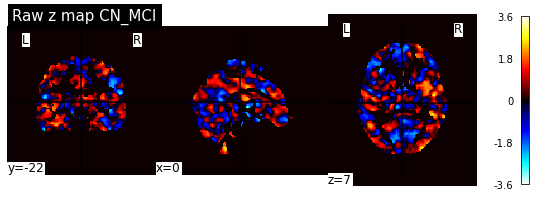

In [43]:
stat_map = niftimasker.inverse_transform(clf_MCI_Zmap).get_data()
output = nib.Nifti1Image(stat_map, header=header, affine=afffine)
nib.save(output, '/home/kadajji/hydra-work/clf_MCI_zmap.nii')
display = plotting.plot_stat_map('/home/kadajji/hydra-work/clf_MCI_zmap.nii', title='Raw z map CN_MCI')

/tmp/ipykernel_10332/2241623270.py:1: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  stat_map = niftimasker.inverse_transform(clf_MCI_mean).get_data()


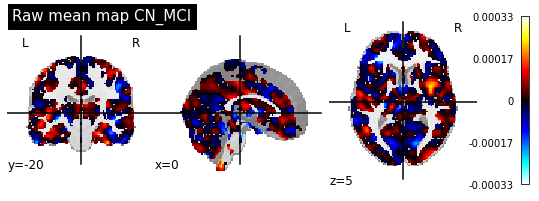

In [44]:
stat_map = niftimasker.inverse_transform(clf_MCI_mean).get_data()
output = nib.Nifti1Image(stat_map, header=header, affine=afffine)
nib.save(output, '/home/kadajji/hydra-work/clf_MCI_mean.nii')
display = plotting.plot_stat_map('/home/kadajji/hydra-work/clf_MCI_mean.nii', title='Raw mean map CN_MCI')

/tmp/ipykernel_10332/816641738.py:18: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  stat_map = niftimasker.inverse_transform(clf_AD_Zmap).get_data()


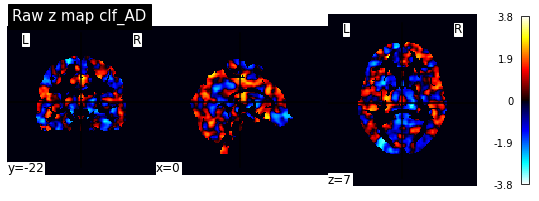

In [45]:
import nibabel as nib
import numpy as np
from nilearn import plotting

clf_AD_mean = clf_AD.mean()
clf_AD_stddeviation = clf_AD.std()
clf_AD_Zmap = clf_AD_mean.div(clf_AD_stddeviation)


path="/home/kadajji/hydra-work/DELCODE_fMRI_GLMs_parametric/data/M0/glm/arcsin_CSF_pop_tpms_0p9_eroded/011d501d1/con_0005.nii"

mean_img = nib.load(mask).get_fdata()
#mean_img  = np.nan_to_num(mean_img)
afffine = nib.load(mask).affine

header = nib.load(mask).header

stat_map = niftimasker.inverse_transform(clf_AD_Zmap).get_data()
output = nib.Nifti1Image(stat_map, header=header, affine=afffine)
nib.save(output, '/home/kadajji/hydra-work/clf_AD_zmap.nii')
display = plotting.plot_stat_map('/home/kadajji/hydra-work/clf_AD_zmap.nii', title='Raw z map clf_AD')

/tmp/ipykernel_10332/1275323583.py:1: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  stat_map = niftimasker.inverse_transform(clf_AD_mean).get_data()


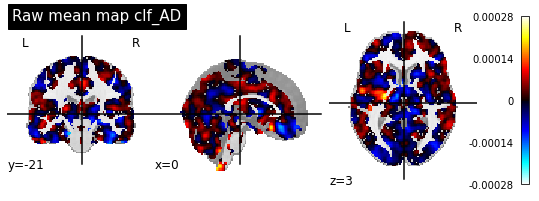

In [46]:
stat_map = niftimasker.inverse_transform(clf_AD_mean).get_data()
output = nib.Nifti1Image(stat_map, header=header, affine=afffine)
nib.save(output, '/home/kadajji/hydra-work/clf_AD_mean.nii')
display = plotting.plot_stat_map('/home/kadajji/hydra-work/clf_AD_mean.nii', title='Raw mean map clf_AD')